# Installations

In [1]:
!pip install docplex
!pip install qiskit_optimization
!pip install cplex
!pip install dwave-ocean-sdk
!pip install pylatexenc
!pip install qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 31.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.28.240-py3-none-any.whl size=682834 sha256=8c72855576c21b670a7de8c03afc9a23776df1f8afefcbca154eeee34bae830a
  Stored in directory: /root/.cache/pip/wheels/1b/ec/59/cc07dedc67b032a492201f6f26c1f3c9e667ef208c9213ba6d
Successfully built docplex
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.

In [2]:
!pip install qiskit-aer-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 MB 14.1 MB/s eta 0:00:00


# Imports

In [3]:
from docplex.mp.model import Model
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit.primitives import Estimator as AerEstimator
from qiskit_algorithms.optimizers import COBYLA

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from dimod import ConstrainedQuadraticModel, Binary
from dwave.samplers import SimulatedAnnealingSampler
from dimod.reference.samplers import ExactCQMSolver


# Utils

In [4]:
def data_bins(results, wj, n, m, l=0, simplify=False):
    """save the results on a dictionary with the three items, bins, items, and index.
    results (cplex.solve): results of the optimization
    wj: (array (1,m): weights of the items
    n: (int) number of items
    m: (int) number of bins
    """
    if simplify:
        bins = np.ones((m,))
        if m-l > 0:
            bins[m-l-1:m] = results[:m-l]
        items = np.zeros((m,n))
        items[:,1:] =  results[m-l:(m-1)*n+m-l].reshape(m,n-1)
        items[0,0] = 1
        items = items.reshape(m,n) * wj
        return {"bins":bins, "items":items,"index":np.arange(m)}
    else:
        return {"bins":results[:m], "items":results[m:m+m*n].reshape(m,n) * wj, "index":np.arange(m)}
def plot_bins(results, wj, n, m, Q, l=0,simplify=False, vqe=False):
    """plot in a bar diagram the results of an optimization bin packing problem"""
    if vqe:
      res = data_bins(results, wj, n, m, l, simplify)
    else:
      res = data_bins(results.x, wj, n, m, l, simplify)
    plt.figure()
    ind = res["index"]
    plt.bar(ind, res["items"][:,0], label=f"item {0}")
    suma = bottom=res["items"][:,0]
    for j in range(1,n):
        plt.bar(ind, res["items"][:,j], bottom=suma, label=f"item {j}")
        suma += res["items"][:,j]
    plt.hlines(Q,0-0.5,m-0.5,linestyle="--", color="r",label="Max W")
    plt.xticks(ind)
    plt.xlabel("Bin")
    plt.ylabel("Weight")
    plt.legend()

In [5]:
def quantum_annealing_solver(I, w, B, n, num_items):
  cqm = ConstrainedQuadraticModel()

  # creating the binary variable for bins
  bin_used = [Binary(f'bin_used_{j}') for j in range(num_items)]
  item_in_bin = [[Binary(f'item_{i}_in_bin_{j}') for i in range(num_items)]
      for j in range(n)]

  # objective function
  cqm.set_objective(sum(bin_used))

  #constraints
  for i in range(num_items):
      one_bin_per_item = cqm.add_constraint(sum(item_in_bin[i]) == 1, label=f'item_placing_{i}')

  for j in range(num_items):
      bin_up_to_capacity = cqm.add_constraint(
          sum(w[i] * item_in_bin[i][j] for i in range(num_items)) - bin_used[j] * B <= 0,
          label=f'capacity_bin_{j}')


In [6]:
# let n = number of items
# let m = number of bins, UB = n
# Define the ILP formulation of the BPP
def create_bin_packing_ILP(I, wj, Q, n):
  m = len(I)
  mdl = Model(name="BinPacking")
  # y_j: binary variable that is 1 if bin j is used, 0 otherwise
  x = mdl.binary_var_list([f"x{i}" for i in range(n)]) # list of variables that represent the bins
  e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

  objective = mdl.sum([x[i] for i in range(n)])

  mdl.minimize(objective)

  for j in range(m):
      # First set of constraints: the items must be in any bin
      constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
      mdl.add_constraint(constraint0 == 1, f"cons0,{j}")

  for i in range(n):
      # Second set of constraints: weight constraints
      constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
      mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")

  return mdl, x, e

def simplify_model(I, wj, Q, n):
  mdl = Model("BinPacking_simplify")
  m = len(I)
  l = int(np.ceil(np.sum(wj)/Q))
  x = mdl.binary_var_list([f"x{i}" for i in range(m)]) # list of variables that represent the bins
  e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

  objective = mdl.sum([x[i] for i in range(n)])

  mdl.minimize(objective)

  for j in range(m):
      # First set of constraints: the items must be in any bin
      constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
      mdl.add_constraint(constraint0 == 1, f"cons0,{j}")

  for i in range(n):
      # Second set of constraints: weight constraints
      constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
      mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")


  # Load quadratic program from docplex model
  qp = QuadraticProgram()
  qp = from_docplex_mp(mdl)
  # Simplifying the problem
  for i in range(l):
      qp = qp.substitute_variables({f"x{i}":1})
  qp = qp.substitute_variables({"e0,0":1})
  for i in range(1,m):
      qp = qp.substitute_variables({f"e{i},0":0})
  print(qp.export_as_lp_string())
  return mdl, qp

# Create a function to transform the ILP model into a QUBO
def convert_to_QUBO(qp):

  ineq2eq = InequalityToEquality()
  qp_eq = ineq2eq.convert(qp)

  int2bin = IntegerToBinary()
  qp_eq_bin = int2bin.convert(qp_eq)

  lineq2penalty = LinearEqualityToPenalty()
  qubo = lineq2penalty.convert(qp_eq_bin)

  return qubo

In [7]:
# brute force solution for BPP

def brute_force(I, w, B, n):
  max_num_bins = len(I)
  bins = [[] for bin in range(max_num_bins)]
  curr_bin = 0

  for item in I:
      # Check if adding the current item exceeds the bin capacity
      if np.sum([w[i] for i in bins[curr_bin]]) + w[item] <= B:
          bins[curr_bin].append(item)
      else:
          curr_bin += 1
          # Ensure that the current bin doesn't exceed the available number of bins
          if curr_bin >= max_num_bins:
              print("Error: Not enough bins to fit all items")
              break
          bins[curr_bin].append(item)

  # Output the number of bins used (curr_bin + 1, since curr_bin is zero-indexed)
  print(f"Number of bins used: {curr_bin + 1}")
  print(f"Item distribution across bins: {bins}")

## Utils: quantum annealing simulations

In [8]:
from dimod import ConstrainedQuadraticModel, Binary
from dwave.samplers import SimulatedAnnealingSampler
from dimod.reference.samplers import ExactCQMSolver

def quantum_annealing_solver(I, w, B, n, num_items):
    cqm = ConstrainedQuadraticModel()

    # creating the binary variable for bins
    bin_used = [Binary(f'bin_used_{j}') for j in range(num_items)]
    item_in_bin = [[Binary(f'item_{i}_in_bin_{j}') for i in range(num_items)]
        for j in range(n)]

    # objective function
    cqm.set_objective(sum(bin_used))

    #constraints
    for i in range(num_items):
        one_bin_per_item = cqm.add_constraint(sum(item_in_bin[i]) == 1, label=f'item_placing_{i}')

    for j in range(num_items):
        bin_up_to_capacity = cqm.add_constraint(
            sum(w[i] * item_in_bin[i][j] for i in range(num_items)) - bin_used[j] * B <= 0,
            label=f'capacity_bin_{j}')

    sampler = ExactCQMSolver()
    sampleset = sampler.sample_cqm(cqm,
                                  time_limit=180,
                                  label="Bin Packing Annealing")
    feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
    if len(feasible_sampleset):
      best = feasible_sampleset.first

    selected_bins = [key for key, val in best.sample.items() if 'bin_used' in key and val]
    print("{} bins are used.".format(len(selected_bins)))

## Utils: VQE

In [12]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit_algorithms import VQE, QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator as QuantumInstance

def validate_solution(binary_solution, item_sizes, bin_capacity, num_items, num_bins):
    bins = [[] for _ in range(num_bins)]
    for i in range(num_items):
        for j in range(num_bins):
            if binary_solution[i * num_bins + j] == 1:
                bins[j].append(item_sizes[i])

    flag = True
    # Check if bin capacities are exceeded
    for bin_idx, bin_items in enumerate(bins):
        total_size = sum(bin_items)
        if total_size > bin_capacity:
            flag *= False
            # print(f"Bin {bin_idx} exceeds capacity with total size {total_size}.")
        else:
            flag *= True
            # print(f"Bin {bin_idx} is valid with total size {total_size}.")

    # Check if every item is placed in exactly one bin
    for i in range(num_items):
        item_placed = sum(binary_solution[i * num_bins + j] for j in range(num_bins))
        if item_placed != 1:
            flag *= False
            # print(f"Item {i} is placed in {item_placed} bins (should be exactly 1).")
        else:
            flag *= True
            # print(f"Item {i} is correctly placed.")
    return flag


def solve_with_vqe(qubo, num_qubits, ansatz_type):
    def threshold_solution(optimal_parameters, threshold=np.pi/2):
      # Convert parameters to binary (0 or 1)
      binary_solution = [1 if param > threshold else 0 for param in optimal_parameters]
      return binary_solution

    op, offset = qubo.to_ising()
    ham_op = op

    gpu_estimator = AerEstimator(
        run_options={"seed": 0},
        transpile_options={"seed_transpiler": 0},)
    gpu_estimator.set_options(device='GPU')
    gpu_estimator.set_options(cuStateVec_enable=True)

    if ansatz_type == "su2":
      ansatz = EfficientSU2(num_qubits, su2_gates=['rx', 'y'], entanglement='circular', reps=3)
    elif ansatz_type == "two local":
      ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=3)

    optimizer = COBYLA(maxiter=1000)

    # Create VQE instance
    vqe = VQE(gpu_estimator, ansatz=ansatz, optimizer=optimizer, )

    # Solve using VQE
    result = vqe.compute_minimum_eigenvalue(ham_op)

    return result

def sample_vqe_results(qubo, num_qubits, ansatz_type="su2"):

  result = solve_with_vqe(qubo, num_qubits, ansatz_type)
  from qiskit_aer import AerSimulator
  ansatz = result.optimal_circuit.decompose()
  optimal_parameters = result.optimal_parameters

  bound_ansatz = ansatz.assign_parameters(optimal_parameters)
  bound_ansatz.measure_all()

  simulator = AerSimulator()
  job = simulator.run(bound_ansatz, shots=2048)
  sim_result = job.result()
  counts = sim_result.get_counts()

  sorted_bitstrings = sorted(counts.items(), key=lambda item: item[1], reverse=True)

  # Print the most frequent bitstrings
  print("Most frequent bitstrings (likely optimal/near-optimal solutions):")
  for bitstring, frequency in sorted_bitstrings[:3]:
      print(f"Bitstring: {bitstring}, Frequency: {frequency}")

  return sorted_bitstrings

## Utils: QAOA

In [13]:
def qaoa_ansatz(gamma, beta, hamiltonian):
    n_qubits = hamiltonian.num_qubits
    qc = QuantumCircuit(n_qubits)

    # Initialize in a uniform superposition state
    qc.h(range(n_qubits))

    # Apply cost Hamiltonian (e^(-i * gamma * H_cost))
    for pauli_term, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
      evo = PauliEvolutionGate(SparsePauliOp(pauli_term), time=np.real(coeff))
      qc.append(evo, range(n_qubits))

    # Apply mixing Hamiltonian (e^(-i * beta * X))
    for qubit in range(n_qubits):
        qc.rx(2 * beta, qubit)

    return qc

def expectation_value(params, ham_op, estimator):
    gamma, beta = params
    qc = qaoa_ansatz(gamma, beta, ham_op)

    observable = ham_op

    job = estimator.run([qc], [observable])
    result = job.result()

    return np.real(result.values[0])

def optimize_qaoa(hamiltonian, estimator, p=1):
    def cost_function(params):
        return expectation_value(params, hamiltonian, estimator)

    initial_params = np.random.uniform(0, np.pi, 2)

    optimizer = COBYLA(maxiter=100)
    result = minimize(cost_function, initial_params, method="cobyla")

    return result

def run_qaoa():
    # Define the GPU-based AerEstimator
    gpu_estimator = AerEstimator()
    gpu_estimator.set_options(device='GPU')
    gpu_estimator.set_options(cuStateVec_enable=True)


    # Create the problem Hamiltonian
    hamiltonian = ham_op

    # Optimize the QAOA parameters
    result = optimize_qaoa(hamiltonian, gpu_estimator)

    print("Optimal parameters found by QAOA:", result.x)
    print("Optimal value (minimized expectation):", result.fun)


# Code

Define the ILP formulation of the BPP

In [14]:
# Example input data
I = [0, 1, 2]  # Set of items, represented by indices
w = [2, 3, 4]  # Sizes of the items
B = 4      # Bin capacity
n = 3             # Maximum number of bins
num_items = len(I)

# Create the ILP model for bin packing
bin_packing_model, _,_ = create_bin_packing_ILP(I, w, B, n)

In [15]:
qp = QuadraticProgram()
mod = from_docplex_mp(bin_packing_model)
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking

Minimize
 obj: x0 + x1 + x2
Subject To
 cons0,0: _e0,0 + _e1,0 + _e2,0 = 1
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: - 4 x0 + 2 _e0,0 + 3 _e0,1 + 4 _e0,2 <= 0
 cons1,1: - 4 x1 + 2 _e1,0 + 3 _e1,1 + 4 _e1,2 <= 0
 cons1,2: - 4 x2 + 2 _e2,0 + 3 _e2,1 + 4 _e2,2 <= 0

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= _e0,0 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,0 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,0 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x0 x1 x2 _e0,0 _e0,1 _e0,2 _e1,0 _e1,1 _e1,2 _e2,0 _e2,1 _e2,2
End



fval=3.0, x0=1.0, x1=1.0, x2=1.0, e0,0=0.0, e0,1=1.0, e0,2=0.0, e1,0=0.0, e1,1=0.0, e1,2=1.0, e2,0=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


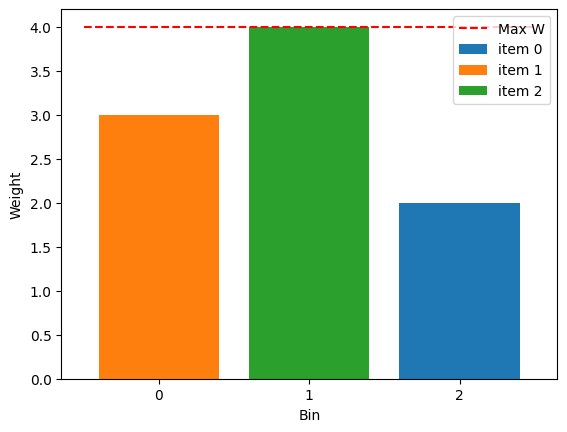

In [16]:
qp = mod

# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, w, n, len(I), B)

In [17]:
simplify_mdl, simplify_qp = simplify_model(I, w, B, n)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: 3
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 3 _e0,1 + 4 _e0,2 <= 2
 cons1,1: 3 _e1,1 + 4 _e1,2 <= 4
 cons1,2: 3 _e2,1 + 4 _e2,2 <= 4

Bounds
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2
End



<class 'numpy.ndarray'>


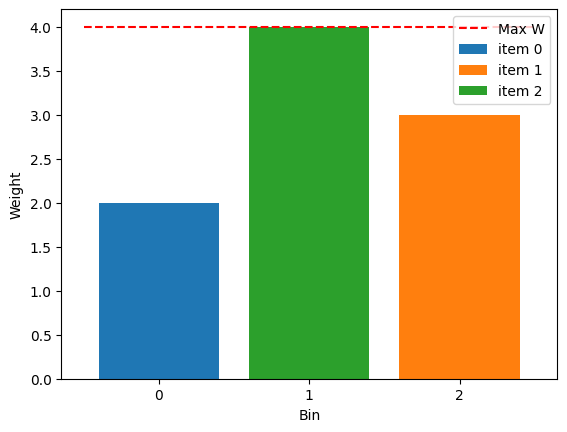

In [18]:
l = int(np.ceil(np.sum(w)/B))
simplify_result = cplex.solve(simplify_qp)
print(type(simplify_result.x))
plot_bins(simplify_result, w, n, len(I), B, l, simplify=True)

Create a function to transform the ILP model into a QUBO

In [19]:
qubo = convert_to_QUBO(simplify_qp)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: - 14 _e0,1 - 18 _e0,2 - 26 _e1,1 - 34 _e1,2 - 26 _e2,1 - 34 _e2,2
      - 4 cons1,0@int_slack@0 - 4 cons1,0@int_slack@1 - 8 cons1,1@int_slack@0
      - 16 cons1,1@int_slack@1 - 8 cons1,1@int_slack@2 - 8 cons1,2@int_slack@0
      - 16 cons1,2@int_slack@1 - 8 cons1,2@int_slack@2 + [ 20 _e0,1^2
      + 48 _e0,1*_e0,2 + 4 _e0,1*_e1,1 + 4 _e0,1*_e2,1
      + 12 _e0,1*cons1,0@int_slack@0 + 12 _e0,1*cons1,0@int_slack@1 + 34 _e0,2^2
      + 4 _e0,2*_e1,2 + 4 _e0,2*_e2,2 + 16 _e0,2*cons1,0@int_slack@0
      + 16 _e0,2*cons1,0@int_slack@1 + 20 _e1,1^2 + 48 _e1,1*_e1,2
      + 4 _e1,1*_e2,1 + 12 _e1,1*cons1,1@int_slack@0
      + 24 _e1,1*cons1,1@int_slack@1 + 12 _e1,1*cons1,1@int_slack@2 + 34 _e1,2^2
      + 4 _e1,2*_e2,2 + 16 _e1,2*cons1,1@int_slack@0
      + 32 _e1,2*cons1,1@int_slack@1 + 16 _e1,2*cons1,1@int_slack@2 + 20 _e2,1^2
      + 48 _e2,1*_e2,2 + 12 _e2,1*cons1,2@int_slack@

Test your function with specific instances (size small, medium, and big)


In [20]:
result = cplex.solve(qubo)
print(result)

fval=3.0, e0,1=0.0, e0,2=0.0, e1,1=1.0, e1,2=0.0, e2,1=0.0, e2,2=1.0, cons1,0@int_slack@0=1.0, cons1,0@int_slack@1=1.0, cons1,1@int_slack@0=1.0, cons1,1@int_slack@1=0.0, cons1,1@int_slack@2=0.0, cons1,2@int_slack@0=0.0, cons1,2@int_slack@1=0.0, cons1,2@int_slack@2=0.0, status=SUCCESS


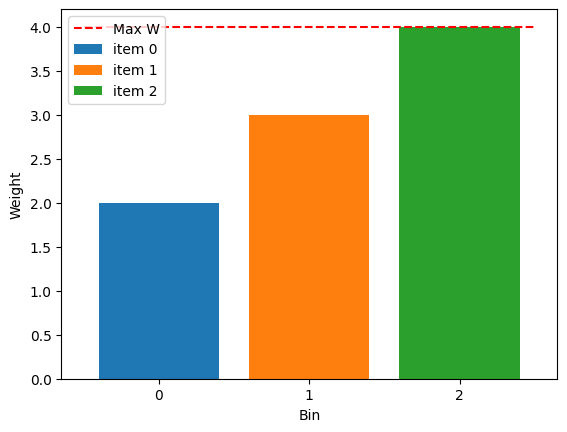

In [21]:
data_bins(result.x, w, n, num_items, l=l, simplify=True)
plot_bins(result, w, n, num_items,B, l=l, simplify=True)

Create a Brute Force solver for the QUBO problem and solve the specific instances.


In [22]:
brute_force(I, w, B, n)

Number of bins used: 3
Item distribution across bins: [[0], [1], [2]]


To solve the QUBO, use quantum annealing simulators. You can use the Dwave Ocean Framework. Here is an example.

In [23]:
qa_solution = quantum_annealing_solver(I, w, B, n, num_items)

3 bins are used.


<ipython-input-8-0e9fe796511d>:26: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'time_limit'
  sampleset = sampler.sample_cqm(cqm,
<ipython-input-8-0e9fe796511d>:26: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'label'
  sampleset = sampler.sample_cqm(cqm,


Use a Quantum Variational approach to solve the QUBO.

In [24]:
op, offset = qubo.to_ising()
bitstrings = sample_vqe_results(qubo, op.num_qubits)

<ipython-input-12-b40951631026>:70: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  result = solve_with_vqe(qubo, num_qubits, ansatz_type)
<ipython-input-12-b40951631026>:70: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  result = solve_with_vqe(qubo, num_qubits, ansatz_type)


Most frequent bitstrings (likely optimal/near-optimal solutions):
Bitstring: 01000000101110, Frequency: 4
Bitstring: 00000010100010, Frequency: 4
Bitstring: 00011100011001, Frequency: 4


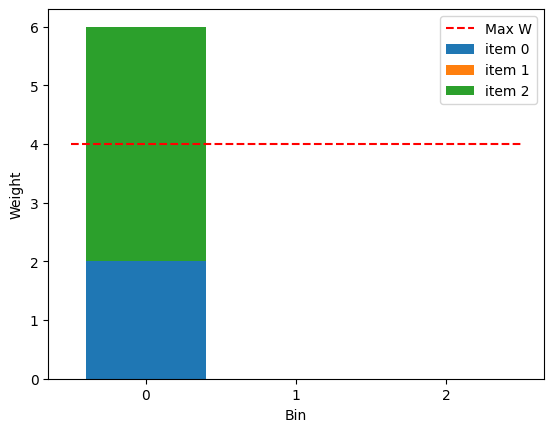

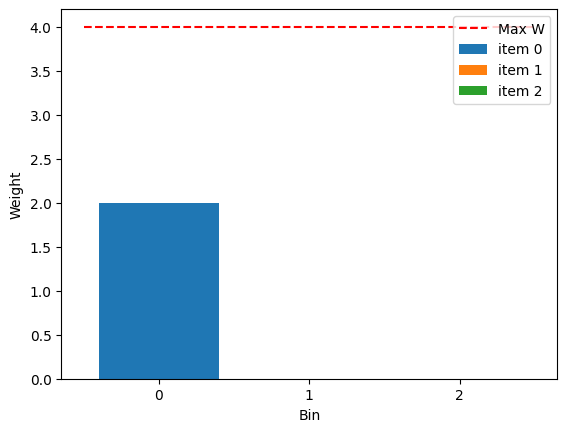

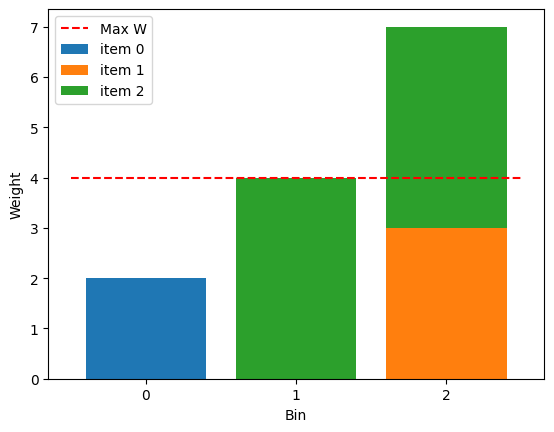

In [25]:
l = int(np.ceil(np.sum(w)/B))
for bitstring in bitstrings[:3]:
  # print(bitstring[0])
  res = np.array([int(bit) for bit in bitstring[0]])
  # flag = validate_solution(res, w, B, num_items, n)
  plot_bins(res, w, n, len(I), B, l, simplify=True, vqe=True)

Use QAOA to solve the QUBO.

In [26]:
op, offset = qubo.to_ising()
ham_op = op
ham_op

SparsePauliOp(['IIIIIIIIIIIIIZ', 'IIIIIIIIIIIZII', 'IIIIIIIIIZIIII', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIZIII', 'IIIIIIIIZIIIII', 'IIIIIIIZIIIIII', 'IIIIIIZIIIIIII', 'IIIIIZIIIIIIII', 'IIIIZIIIIIIIII', 'IIIZIIIIIIIIII', 'IIZIIIIIIIIIII', 'IZIIIIIIIIIIII', 'ZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIIZIZ', 'IIIIIIIIIZIIIZ', 'IIIIIIIZIIIIIZ', 'IIIIIIZIIIIIIZ', 'IIIIIIIIIIZIZI', 'IIIIIIIIZIIIZI', 'IIIIIIIZIIIIZI', 'IIIIIIZIIIIIZI', 'IIIIIIIIIIZZII', 'IIIIIIIIIZIZII', 'IIIIIZIIIIIZII', 'IIIIZIIIIIIZII', 'IIIZIIIIIIIZII', 'IIIIIIIIZIZIII', 'IIIIIZIIIIZIII', 'IIIIZIIIIIZIII', 'IIIZIIIIIIZIII', 'IIIIIIIIZZIIII', 'IIZIIIIIIZIIII', 'IZIIIIIIIZIIII', 'ZIIIIIIIIZIIII', 'IIZIIIIIZIIIII', 'IZIIIIIIZIIIII', 'ZIIIIIIIZIIIII', 'IIIIIIZZIIIIII', 'IIIIZZIIIIIIII', 'IIIZIZIIIIIIII', 'IIIZZIIIIIIIII', 'IZZIIIIIIIIIII', 'ZIZIIIIIIIIIII', 'ZZIIIIIIIIIIII'],
              coeffs=[ -8. +0.j,  -5. +0.j,  -5. +0.j, -10.5+0.j,  -6.5+0.j,  -6.5+0.j,
  -2.5+0.j,  -2.5+0.j,  -1.5+0.j,  -3. +0.j,  -1.5+0.j,  -1.5+0.j,
 

In [27]:
run_qaoa()

<ipython-input-27-00691c529f9b>:1: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  run_qaoa()
<ipython-input-27-00691c529f9b>:1: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  run_qaoa()


Optimal parameters found by QAOA: [2.03269319 0.01991058]
Optimal value (minimized expectation): 0.6806640625


In [28]:
gamma = result.x[0]
beta = result.x[1]

In [29]:
from qiskit.primitives import Sampler

# Step 1: Run the QAOA circuit and sample bitstrings using Sampler
def sample_bitstrings(gamma, beta, hamiltonian, shots=1024):
    qc = qaoa_ansatz(gamma, beta, hamiltonian)

    # Use the Sampler primitive to sample bitstrings
    sampler = Sampler()
    qc.measure_all()
    # Run the circuit with the sampler to get samples
    job = sampler.run(circuits=[qc], shots=shots)
    result = job.result()

    # Get the bitstring samples (counts as a quasi-distribution)
    counts = result.quasi_dists[0]
    return counts

# Step 2: Evaluate the cost function for each bitstring
def evaluate_bitstring(bitstring, hamiltonian):
    """Evaluate the cost (Hamiltonian value) for a given bitstring."""
    bit_array = np.array([1 if b == '1' else -1 for b in bitstring])  # Convert '1' -> 1, '0' -> -1
    cost = 0.0
    for pauli, coeff in zip(hamiltonian.primitive.paulis, hamiltonian.coeffs):
        value = np.prod([bit_array[i] if p != 'I' else 1 for i, p in enumerate(pauli.to_label())])
        cost += coeff * value
    return cost.real

# Step 3: Post-processing to find the best bitstring
def find_best_bitstring(counts, hamiltonian):
    """Given sampled bitstrings and their counts, find the best bitstring."""
    best_bitstring = None
    best_cost = float('inf')

    # Convert quasi-probability distribution to actual bitstrings and evaluate them
    for bitstring, count in counts.items():
        bitstring = format(int(bitstring, 16), f'0{hamiltonian.num_qubits}b')  # Convert hex to binary string
        cost = evaluate_bitstring(bitstring, hamiltonian)
        if cost < best_cost:
            best_cost = cost
            best_bitstring = bitstring

    return best_bitstring, best_cost

<ipython-input-29-6148a78df942>:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


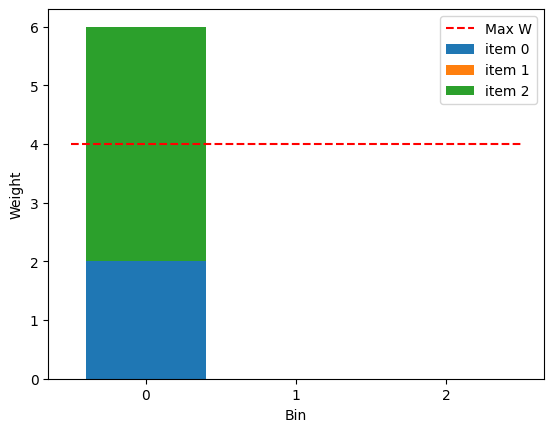

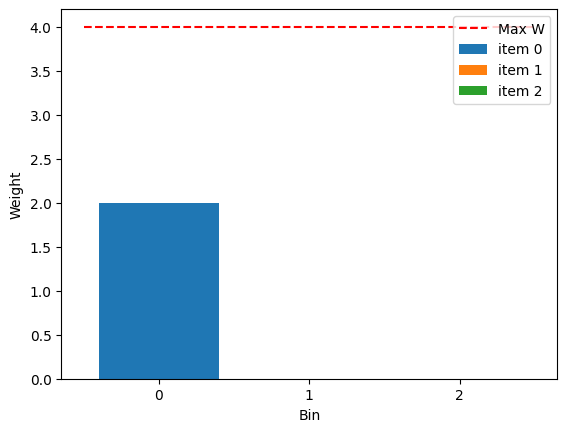

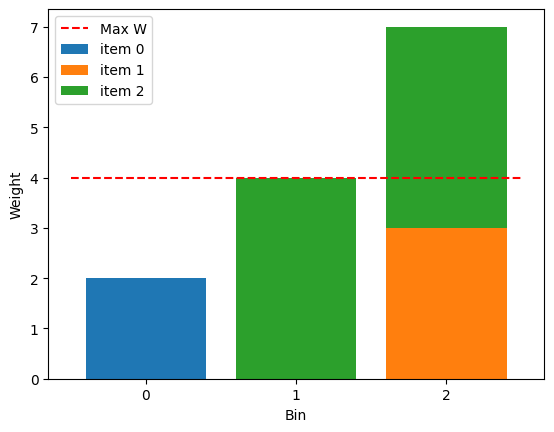

In [30]:
bitsrings = sample_bitstrings(gamma, beta, ham_op)
l = int(np.ceil(np.sum(w)/B))
for bitstring in bitstrings[:3]:
  # print(bitstring[0])
  res = np.array([int(bit) for bit in bitstring[0]])
  # flag = validate_solution(res, w, B, num_items, n)
  plot_bins(res, w, n, len(I), B, l, simplify=True, vqe=True)

# Compare and analyze the results

What is the difference between QAOA, Quantum Annealing, and Quantum Variational approaches with different Ansatz?

| **Feature**                     | **QAOA**                                                      | **Quantum Annealing**                                         | **Variational Quantum Approaches (VQE)**                    |
|----------------------------------|---------------------------------------------------------------|---------------------------------------------------------------|-------------------------------------------------------------|
| **Quantum-Classical Hybrid**     | Yes, classical optimization for parameter tuning              | No, fully quantum but evolves the system adiabatically         | Yes, classical optimizer for ansatz parameter tuning         |
| **Ansatz**                       | Yes, fixed (problem-inspired) ansatz                          | No ansatz, natural evolution under problem Hamiltonian         | Yes, customizable ansatz (e.g., UCCSD, hardware-efficient)   |
| **Optimization Focus**           | Combinatorial optimization (e.g., MAXCUT, QUBO)               | Optimization problems formulated as Ising/QUBO problems        | Broad (e.g., quantum chemistry, combinatorial optimization)  |
| **Quantum Circuit Depth**        | Depends on \( p \) layers (increases with accuracy)           | Not gate-based (analog computation)                           | Varies by ansatz, depth increases with accuracy and complexity |
| **Energy Landscape Exploration** | Explores discrete solutions by varying quantum circuit layers | Gradual energy minimization by adiabatic evolution             | Energy minimization using quantum circuit and classical optimizer |
| **Hardware Requirements**        | Gate-based quantum computers (IBM Q, Rigetti, etc.)           | Specialized hardware (D-Wave, quantum annealers)               | Gate-based quantum computers                                 |


How do the results compare with the brute force approach?

For smaller problem instances, the brute force approach outperforms both the variational algorithm and QAOA in terms of accuracy. However, quantum annealing consistently provides accurate results across all problem sizes, maintaining its performance even as the problem scales.